# Analyzing business potential of areas in Pune, India

### Table of contents

* Getting the coordinates of decided locations

#### Importing required libraries

In [60]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim      # geolocation library
import requests                          # to handle requests to urls

#### Function to get coordinates from list of address

In [2]:
def get_coordinates(address_list):
    geolocator = Nominatim(user_agent="wain")
    locations = pd.DataFrame(columns=['Area name', 'latitude', 'longitude'])
    for address in address_list:
        try:
            location = geolocator.geocode(address)
            latitude = location.latitude
            longitude = location.longitude
        except:
            latitude = 'Address not found'
            longitude = 'Address not found'
        locations = locations.append(
            {
                'Area name': address,
                'latitude': latitude,
                'longitude': longitude
            },
            ignore_index=True)
    return locations

In [30]:
# list of areas that I decided upon, venues around these locations will be used
address = ['Shankar Kalat nagar','Pimpri-Chinchwad','Aundh,Pune','Kothrud','Koregaon Park']
locations = get_coordinates(address)
locations

,Area name,latitude,longitude
0,Shankar Kalat nagar,18.604093,73.754065
1,Pimpri-Chinchwad,18.627929,73.800983
2,"Aundh,Pune",18.561883,73.810196
3,Kothrud,18.503889,73.807673
4,Koregaon Park,18.537553,73.893925


#### Defining Foursquare credentials

In [31]:
# hide this cell
# credential foursquare API
CLIENT_ID = 'DMMNDCKP4HCEBKNG0OZUKP4HQ4G2ARKETXFJLZOI1DY001IT' # your Foursquare ID
CLIENT_SECRET = 'BNOTBJCDHCHRJ3Z1EAMLB0TXSCA4RUH1HSABRTIV33ERSMAM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [32]:
import json
from pandas.io.json import json_normalize

In [33]:
def get_venues(lat, lon):
    LIMIT = 100
    radius = 5000
    try:
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, radius, LIMIT)
        results = requests.get(url).json()
        venues = results['response']['groups'][0]['items']
        nearby_venues = json_normalize(venues)  # flatten JSON
        filtered_columns = [
            'venue.name', 'venue.categories', 'venue.location.lat',
            'venue.location.lng'
        ]
        nearby_venues = nearby_venues.loc[:, filtered_columns]
        nearby_venues['venue.categories'] = nearby_venues.apply(
            get_category_type, axis=1)
        nearby_venues.columns = [
            col.split(".")[-1] for col in nearby_venues.columns
        ]

    except:
        return None

    return nearby_venues

In [34]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [35]:
df_venues = pd.DataFrame(columns=['name','categories','lat','lng'])
for i in range (0,len(locations.index)):
    df_venues = df_venues.append(get_venues(locations.latitude[i],locations.longitude[i]))
    
df_venues.shape

(498, 4)

In [36]:
df_venues.reset_index(drop=True, inplace=True)
df_venues.head()

,name,categories,lat,lng
0,Sayaji,Hotel,18.599535,73.754995
1,Natural Ice Cream,Ice Cream Shop,18.591192,73.752440
2,Barbeque Nation,BBQ Joint,18.599390,73.755090
3,Courtyard by Marriott,Hotel,18.591527,73.746831
4,Little Italy,Italian Restaurant,18.591513,73.743668


In [37]:
df_venues = df_venues.drop_duplicates()

In [38]:
df_venues.shape

(429, 4)

In [39]:
import folium

In [40]:
map_ = folium.Map(location=[locations.latitude[2], locations.longitude[2]], zoom_start=12)

# add markers to map
for lat, lng, Categories, name in zip(df_venues['lat'], df_venues['lng'], df_venues['categories'], df_venues['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_)  
    
map_

In [41]:
df_venues.to_csv('venues_all.csv',index=False)

In [42]:
Clus_dataSet = df_venues[['lat','lng']] 
Clus_dataSet.head()

,lat,lng
0,18.599535,73.754995
1,18.591192,73.752440
2,18.599390,73.755090
3,18.591527,73.746831
4,18.591513,73.743668


In [43]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from folium import plugins
import matplotlib.pyplot as plt

In [44]:
scaler = StandardScaler()
Clus_dataSet_scale = scaler.fit_transform(Clus_dataSet)
Clus_dataSet_scale[0:5]

array([[ 0.85212735, -1.23989592],
       [ 0.65993112, -1.29012161],
       [ 0.84876854, -1.23802537],
       [ 0.66765555, -1.40034594],
       [ 0.66732645, -1.46251123]])

In [45]:
dist = []
list_k = list(range(1, 12))      # list of values of k to test for

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(Clus_dataSet_scale)
    dist.append(km.inertia_)   

Text(0, 0.5, 'Sum of squared distance')

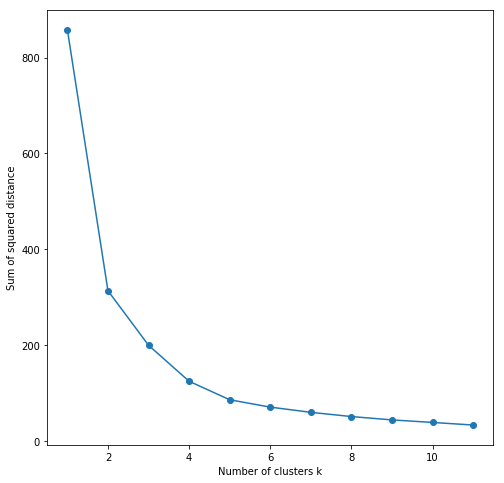

In [46]:
# Plot dist against k
plt.figure(figsize=(8, 8))
plt.plot(list_k, dist, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distance')

In [47]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet_scale)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 3, 0, 3, 0, 2, 3, 0, 0, 3,
       0, 0, 2, 2, 3, 3, 2, 3, 3, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 3, 3, 3,
       3, 3, 2, 0, 3, 0, 0, 3, 0, 3, 3, 0, 3, 3, 0, 0, 3, 0, 0, 0, 0, 2,
       2, 3, 3, 2, 3, 3, 3, 0, 0, 0, 3, 3, 2, 0, 0, 3, 3, 0, 0, 3, 3, 3,
       3, 3, 3, 2, 0, 0, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 3, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
       0, 4, 0, 4, 4, 0, 4, 4, 4, 0, 4, 0, 4, 0, 4, 0, 4, 4, 0, 4, 0, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [58]:
color_options = [
    'black', 'blue', 'red', 'purple', 'darkgreen', 'darkpurple',
    'darkred', 'gray', 'green', 'lightblue', 'lightgreen', 'lightred',
    'orange', 'pink'
]
map_clus = folium.Map(location=[locations.latitude[2], locations.longitude[2]],
                      zoom_start=11)
# add markers to map
for lat, lng, Categories, name, lab in zip(df_venues['lat'], df_venues['lng'],
                                           df_venues['categories'],
                                           df_venues['name'], labels):
    label = '{}, {}'.format(name, Categories, lab)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=1,
                        popup=label,
                        color=color_options[lab],
                        fill=True,
                        fill_opacity=1,
                        parse_html=False).add_to(map_clus)

map_clus

In [53]:
df_venues.insert(0, 'Cluster Labels', labels)
df_venues.head()

,Cluster Labels,name,categories,lat,lng
0,3,Sayaji,Hotel,18.599535,73.754995
1,3,Natural Ice Cream,Ice Cream Shop,18.591192,73.752440
2,3,Barbeque Nation,BBQ Joint,18.599390,73.755090
3,3,Courtyard by Marriott,Hotel,18.591527,73.746831
4,3,Little Italy,Italian Restaurant,18.591513,73.743668


In [23]:
cluster_centres = kmeans.cluster_centers_
cluster_centres

array([[-0.35330509,  1.30747228],
       [ 1.26645644, -1.27417529],
       [-1.00570617,  0.09230428],
       [ 0.35029598, -0.59847025],
       [ 2.43172058, -1.0015543 ]])

In [24]:
from scipy import spatial

In [25]:
idx = []
for i in range(0,len(cluster_centres)):
    dist,index = spatial.KDTree(Clus_dataSet_scale).query(cluster_centres[i])
    idx.append(index)
idx

[273, 67, 202, 119, 17]

In [26]:
center_coord = Clus_dataSet.iloc[idx][['lat','lng']]
center_coord

,lat,lng
313,18.536643,73.896771
67,18.591830,73.756950
229,18.515930,73.829225
119,18.559476,73.790409
17,18.627925,73.780808


In [48]:
center_coord_index = center_coord.index.values.tolist()
center_coord_index

[313, 67, 229, 119, 17]

In [51]:
def get_address(coordinates_list):
    reverse_geolocator = Nominatim(user_agent="wain")
    area_name = []
    for coord in coordinates_list:
        try:
            address = reverse_geolocator.reverse(coord)
            x = str(address)
            area_name.append(x.split(',')[-6])
        except:
            x = 'Address not found'
            area_name.append(x)        
    return area_name

In [50]:
locator_ = Nominatim(user_agent="wain")
addre = locator.reverse(Clus_dataSet.iloc[73][['lat','lng']])
addre

Location(Akshay, Balewadi Gaon Road, Chakankar Mala, Baner, Pune, Pune District, Maharashtra, 411001, India, (18.5692493, 73.7819239, 0.0))

In [54]:
Cluster_0 = df_venues.loc[df_venues['Cluster Labels'] == 0]
Cluster_0

,Cluster Labels,name,categories,lat,lng
9,0,Urban Foundry,Lounge,18.569289,73.774725
10,0,Incognito,Italian Restaurant,18.570376,73.774607
12,0,CopaCabana,Indian Restaurant,18.589074,73.782483
14,0,Shaolin- The Chinese Cuisine,Chinese Restaurant,18.588343,73.783514
16,0,Way Down South,South Indian Restaurant,18.566366,73.770707
19,0,Nawab Asia,Indian Restaurant,18.569553,73.774668
20,0,McDonald's,Fast Food Restaurant,18.570421,73.774619
22,0,Playboy Beer Garden,Brewery,18.570494,73.773901
23,0,Terttulia,Bistro,18.569280,73.774695
31,0,Subway,Sandwich Place,18.596270,73.789194


In [56]:
Cluster_0_coord = Cluster_0[['lat','lng']].values.tolist()
Cluster_0_coord

[[18.569289409666702, 73.7747245463514],
 [18.570376414375, 73.77460705928516],
 [18.589073641597903, 73.78248319675856],
 [18.58834307568542, 73.78351414844718],
 [18.56636563963199, 73.77070666006395],
 [18.569553019776944, 73.77466783664346],
 [18.570420602793007, 73.77461905317524],
 [18.57049357355062, 73.77390083744952],
 [18.569279945639824, 73.77469467616115],
 [18.59626968572755, 73.78919408694685],
 [18.593509493723708, 73.78587861112443],
 [18.568349587226646, 73.76667067485646],
 [18.593421044897106, 73.79546073318592],
 [18.59556549976012, 73.78851137166053],
 [18.569373153385165, 73.77473114995384],
 [18.5884689083151, 73.7828346796342],
 [18.574754959252665, 73.77732956313457],
 [18.593470321716094, 73.78618117715833],
 [18.570498974751526, 73.7739517705572],
 [18.593440105175873, 73.78608253616997],
 [18.59317580232594, 73.79839888049898],
 [18.566741779358132, 73.7695464347438],
 [18.57046168149214, 73.77414273325013],
 [18.570104742234818, 73.77468498677447],
 [18.592

In [57]:
area_name = get_address(Cluster_0_coord)
area_name

[' Mhalunge',
 ' Mhalunge',
 ' Balewadi',
 ' Balewadi',
 ' Mhalunge',
 ' Mhalunge',
 ' Mhalunge',
 ' Mhalunge',
 ' Mhalunge',
 ' Pimple Saudagar',
 ' Pimple Saudagar',
 ' Mhalunge',
 ' Pimple Saudagar',
 ' Pimple Saudagar',
 ' Mhalunge',
 ' Balewadi',
 ' Mhalunge',
 ' Pimple Saudagar',
 ' Mhalunge',
 ' Pimple Saudagar',
 ' Pimple Saudagar',
 ' Mhalunge',
 ' Mhalunge',
 ' Mhalunge',
 ' Pimple Saudagar',
 'Address not found',
 ' Balewadi',
 ' Baner',
 'Address not found',
 'Address not found',
 ' Mhalunge',
 ' Mhalunge',
 ' Pimple Saudagar',
 'Address not found',
 ' Mhalunge',
 ' Mhalunge',
 ' Pimple Saudagar',
 ' Pimple Saudagar',
 'Address not found',
 'Address not found',
 'Address not found',
 'Address not found',
 'Address not found',
 ' Pimple Saudagar',
 ' Pimple Saudagar',
 ' Pimple Saudagar',
 ' Kasarwadi',
 ' Pimple Saudagar',
 ' Thergaon',
 ' Pimple Saudagar',
 ' Pimple Saudagar',
 ' Balewadi',
 ' Pimple Saudagar',
 'Address not found',
 ' Balewadi',
 ' Pimple Nilakh',
 ' Bale

In [150]:
Cluster_0.insert(0, 'Area_name', area_name)
Cluster_0.head()

NameError: name 'area_name' is not defined

In [149]:
Cluster_0

,Cluster Labels,name,categories,lat,lng
9,0,Urban Foundry,Lounge,18.569289,73.774725
10,0,Incognito,Italian Restaurant,18.570376,73.774607
12,0,CopaCabana,Indian Restaurant,18.589074,73.782483
14,0,Shaolin- The Chinese Cuisine,Chinese Restaurant,18.588343,73.783514
16,0,Way Down South,South Indian Restaurant,18.566366,73.770707
19,0,Nawab Asia,Indian Restaurant,18.569553,73.774668
20,0,McDonald's,Fast Food Restaurant,18.570421,73.774619
22,0,Playboy Beer Garden,Brewery,18.570494,73.773901
23,0,Terttulia,Bistro,18.569280,73.774695
31,0,Subway,Sandwich Place,18.596270,73.789194
